In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
from collections import OrderedDict

from models.seir_testing import SEIR_Testing
from utils.utils import init_params, create_plots

In [11]:
def create_dataframe(df, column_name='RecoveredCases'):
    cases_matrix = df.to_numpy()[:, 4:]
    cases_array = cases_matrix.reshape(-1, 1)

    province_info_matrix = df.to_numpy()[:, :4]
    province_info_array = np.repeat(province_info_matrix, cases_matrix.shape[1], axis=0)

    date = pd.to_datetime(df.columns[4:])
    date_array = np.tile(date, cases_matrix.shape[0]).reshape(-1, 1)

    data = np.concatenate((province_info_array, date_array, cases_array), axis=1)
    df = pd.DataFrame(data=data, columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date', column_name])
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [12]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

df_confirmed = create_dataframe(df_confirmed, 'ConfirmedCases')
df_death = create_dataframe(df_death, 'Deaths')
df_recovered = create_dataframe(df_recovered, 'RecoveredCases')

In [21]:
df_master = df_confirmed.merge(df_death, how='outer').merge(df_recovered, how='outer')
df_master['ActiveCases'] = df_master['ConfirmedCases'] - df_master['Deaths'] - df_master['RecoveredCases']

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Deaths,RecoveredCases,ActiveCases
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0
1,NaN,Afghanistan,33.0000,65.0000,2020-01-23,0,0,0,0
2,NaN,Afghanistan,33.0000,65.0000,2020-01-24,0,0,0,0
3,NaN,Afghanistan,33.0000,65.0000,2020-01-25,0,0,0,0
4,NaN,Afghanistan,33.0000,65.0000,2020-01-26,0,0,0,0
...,...,...,...,...,...,...,...,...,...
19457,NaN,Timor-Leste,-8.8742,125.7275,2020-03-31,NaN,NaN,0,NaN
19458,NaN,Timor-Leste,-8.8742,125.7275,2020-04-01,NaN,NaN,0,NaN
19459,NaN,Timor-Leste,-8.8742,125.7275,2020-04-02,NaN,NaN,0,NaN
19460,NaN,Timor-Leste,-8.8742,125.7275,2020-04-03,NaN,NaN,0,NaN


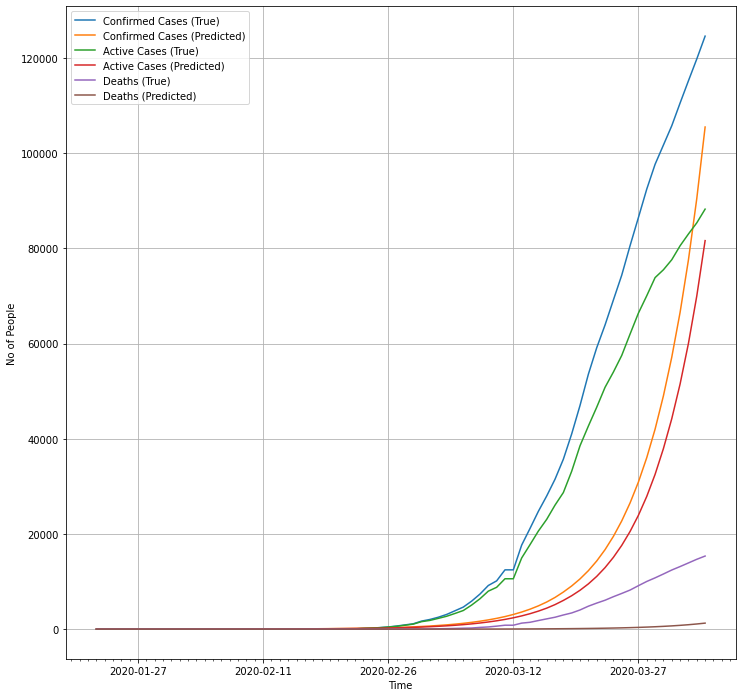

In [49]:
df_country = df_master[df_master['Country/Region'] == 'Italy'].loc[:, 'Date':].groupby('Date').sum().reset_index()
df_country[df_country['ConfirmedCases'] > 0]
last_time = len(df_country['Date'])

states_time_matrices = []
vanilla_params, testing_params, state_init_values = init_params(R0=2.6, T_inc=5.2, T_inf=2.9, T_death=1, N=6.05e7, init_infected=1)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['ConfirmedCases'], label='Confirmed Cases (True)')
ax.plot(np.array(df_country['Date']), states_time_matrix[2] + states_time_matrix[4] + 
        states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
        states_time_matrix[9] + states_time_matrix[10], label='Confirmed Cases (Predicted)')
ax.plot(df_country['Date'], df_country['ActiveCases'], label='Active Cases (True)')
ax.plot(df_country['Date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
        states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label='Active Cases (Predicted)')
ax.plot(df_country['Date'], df_country['Deaths'], label='Deaths (True)')
ax.plot(df_country['Date'], states_time_matrix[10], label='Deaths (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()